In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from github import Github
from datetime import datetime
import geoplot
import geopandas


plt.rcParams["figure.figsize"] = (12, 8)


In [3]:
who_daily_reports_dir_name = "who_daily_reports"

## Download WHO daily reports data

In [4]:
who_repo_name = "CSSEGISandData/COVID-19"
who_repo_daily_reports_dir_path = "csse_covid_19_data/csse_covid_19_daily_reports"

In [5]:
# github = Github("user", "password") # Using authenticated connection changes api limit from 60 per hour to 5000 per hour
github = Github()
repo = github.get_repo(who_repo_name)
reports_dir_content = repo.get_contents(who_repo_daily_reports_dir_path)

In [6]:
reports = list(filter(lambda report: ".csv" in report.name, reports_dir_content))
reports[:5]

[ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-22-2020.csv"),
 ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-23-2020.csv"),
 ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-24-2020.csv"),
 ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-25-2020.csv"),
 ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-26-2020.csv")]

In [7]:
try:
    os.mkdir(who_daily_reports_dir_name)
    print("Created directory", who_daily_reports_dir_name)
except FileExistsError:
    print('WHO daily reports directory already exists')
    
for report in reports:
    try:
        report_file_path = os.path.join(who_daily_reports_dir_name, report.name)
        report_file = open(report_file_path, 'x')
        report_file.write(report.decoded_content.decode('utf-8'))
        report_file.close()
        print("Created report file", report_file_path)
    except FileExistsError:
        print("Daily report file", report_file_path, "already exists")
    except RateLimitExceededException:
        print("API rate limit exceeded, try again in an hour")
        report_file.close()
        os.remove(report_file_path)
        break

WHO daily reports directory already exists
Daily report file who_daily_reports/01-22-2020.csv already exists
Daily report file who_daily_reports/01-23-2020.csv already exists
Daily report file who_daily_reports/01-24-2020.csv already exists
Daily report file who_daily_reports/01-25-2020.csv already exists
Daily report file who_daily_reports/01-26-2020.csv already exists
Daily report file who_daily_reports/01-27-2020.csv already exists
Daily report file who_daily_reports/01-28-2020.csv already exists
Daily report file who_daily_reports/01-29-2020.csv already exists
Daily report file who_daily_reports/01-30-2020.csv already exists
Daily report file who_daily_reports/01-31-2020.csv already exists
Daily report file who_daily_reports/02-01-2020.csv already exists
Daily report file who_daily_reports/02-02-2020.csv already exists
Daily report file who_daily_reports/02-03-2020.csv already exists
Daily report file who_daily_reports/02-04-2020.csv already exists
Daily report file who_daily_repor

## WHO daily reports basic analysis

In [8]:
column_names = ['Province/State', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered']

reports_files = sorted(os.listdir(who_daily_reports_dir_name))
reports = []
for report_file in reports_files:
    date = datetime.strptime(report_file[:-4], '%m-%d-%Y')
    dataframe = pd.read_csv(os.path.join(who_daily_reports_dir_name, report_file))[column_names]

    dataframe['Province/State'].fillna("NotSpecified", inplace=True)
    dataframe.fillna(0, inplace=True)

    dataframe = dataframe.astype({'Confirmed': 'int32', 'Deaths': 'int32', 'Recovered': 'int32'}, copy=False)
    
    reports.append((date, dataframe))


In [9]:
print(reports[0][1].dtypes)
print(reports[0][0])
reports[0][1]

Province/State    object
Country/Region    object
Confirmed          int32
Deaths             int32
Recovered          int32
dtype: object
2020-01-22 00:00:00


,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,Anhui,Mainland China,1,0,0
1,Beijing,Mainland China,14,0,0
2,Chongqing,Mainland China,6,0,0
3,Fujian,Mainland China,1,0,0
4,Gansu,Mainland China,0,0,0
5,Guangdong,Mainland China,26,0,0
6,Guangxi,Mainland China,2,0,0
7,Guizhou,Mainland China,1,0,0
8,Hainan,Mainland China,4,0,0
9,Hebei,Mainland China,1,0,0


[547, 639, 916, 1399, 2062, 2863, 5494, 6070, 8124, 9783, 11871, 16607, 19693, 23680, 27409, 30553, 34075, 36778, 39790, 42306, 44327, 44699, 59832, 66292, 68347, 70446, 72364, 74139, 74546, 74999, 75472, 76922, 76938, 77152, 77660, 78065, 78498, 78824, 79251, 79826, 80026, 80151, 80271, 80422, 80573, 80652, 80699, 80735, 80757, 0, 0, 80945, 80977, 81003]


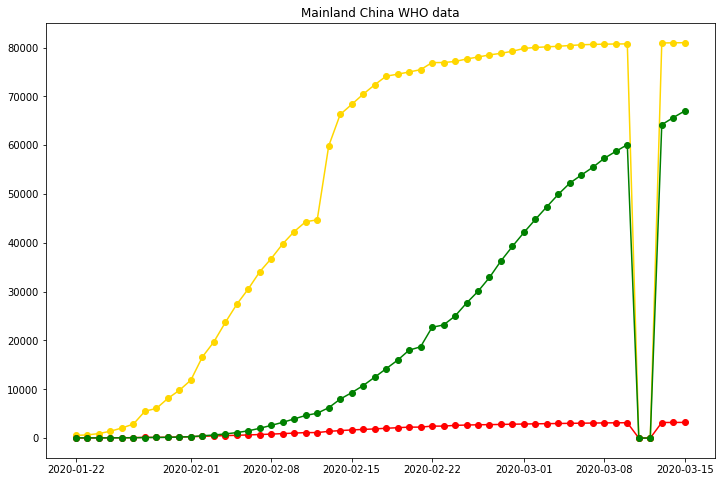

In [10]:
report = reports[0][1]

dates = []
mainland_china_confirmed = []
mainland_china_deaths = []
mainland_china_recovered = []

for report in reports:
    dates.append(report[0])
    region_aggregated_stats = report[1].groupby('Country/Region').sum()
    try:
        mainland_china_stats = region_aggregated_stats.loc['Mainland China', :]
    except:
        mainland_china_stats = region_aggregated_stats.loc['China', :]
    mainland_china_confirmed.append(mainland_china_stats['Confirmed'])
    mainland_china_deaths.append(mainland_china_stats['Deaths'])
    mainland_china_recovered.append(mainland_china_stats['Recovered'])

print(mainland_china_confirmed)
fig, ax = plt.subplots()
ax.set_title('Mainland China WHO data')
ax.plot(dates, mainland_china_confirmed, 'o-', c='gold')
ax.plot(dates, mainland_china_deaths, 'o-', c='red')
ax.plot(dates, mainland_china_recovered, 'o-', c='green')
plt.show()

In [11]:
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
last_report = reports[len(reports)-1][1].groupby("Country/Region")
the_report = last_report.sum()
the_report["country"] = the_report.index.values
merged = world.set_index('name').join(the_report.set_index("country"))
merged.head()


,pop_est,continent,iso_a3,gdp_md_est,geometry,Confirmed,Deaths,Recovered
name,,,,,,,,
Fiji,920938,Oceania,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN,NaN
Tanzania,53950935,Africa,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",NaN,NaN,NaN
W. Sahara,603253,Africa,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN
Canada,35623680,North America,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",250.0,1.0,8.0
United States of America,326625791,North America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",NaN,NaN,NaN


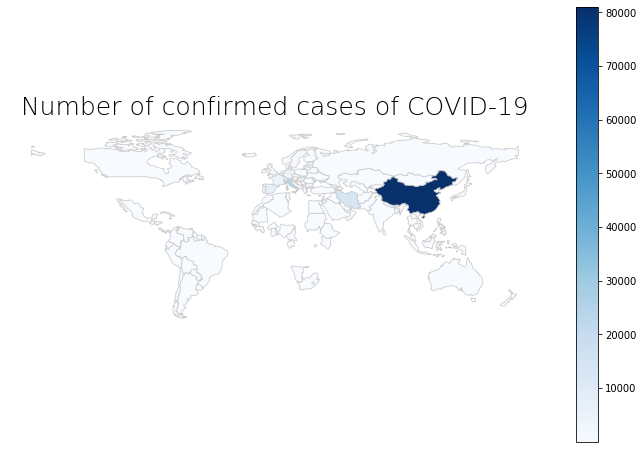

In [12]:
def create_plot_for_map(column_name, df, title):
    fig, ax = plt.subplots(1)
    ax.axis('off')
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
    vmin, vmax = df[column_name].min(), df[column_name].max()
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)
    return ax
    
ax = create_plot_for_map("Confirmed", merged, "Number of confirmed cases of COVID-19")   
merged.plot(column="Confirmed", cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')


In [13]:
merged_with_names = merged
merged_with_names["name"] = merged.index.values
europe = merged_with_names.query('continent == "Europe"')

europe_without_russia = europe[europe['name'] != 'Russia']

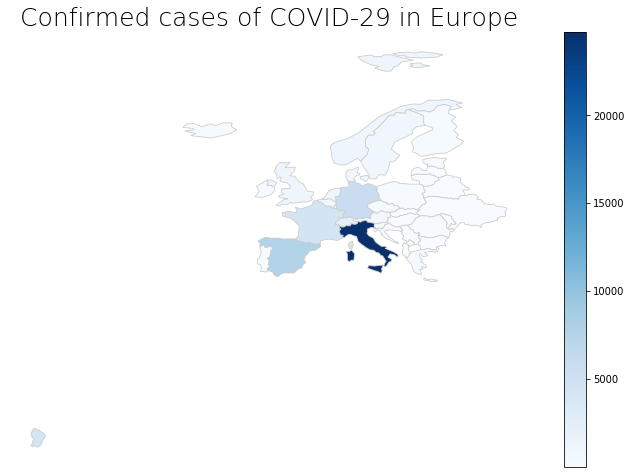

In [14]:
ax = create_plot_for_map("Confirmed", europe_without_russia, "Confirmed cases of COVID-29 in Europe")
europe_without_russia.plot(column="Confirmed", cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

In [15]:
# population data is from https://worldpopulationreview.com/

population = pd.read_csv("popultion.csv")
population["pop2020"] *= 1000
population[population['name'] == 'Poland']["pop2020"]

37    37846611.0
Name: pop2020, dtype: float64

In [16]:
procentage_2019 = the_report.set_index('country').join(population.set_index("name"))
procentage_cleaned = procentage_2019[
    ['Confirmed', 'Deaths', 'Recovered','pop2020']]
procentage_cleaned["country"] = procentage_cleaned.index.values
procentage_cleaned

/home/julia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Confirmed,Deaths,Recovered,pop2020,country
country,,,,,
Afghanistan,16,0,0,38928346.0,Afghanistan
Albania,42,1,0,2877797.0,Albania
Algeria,48,4,12,43851044.0,Algeria
Andorra,1,0,1,77265.0,Andorra
Antigua and Barbuda,1,0,0,97929.0,Antigua and Barbuda
...,...,...,...,...,...
Uruguay,4,0,0,3473730.0,Uruguay
Uzbekistan,1,0,0,33469203.0,Uzbekistan
Venezuela,10,0,0,28435940.0,Venezuela


In [17]:
procentage = procentage_cleaned
procentage["confirmed_proc"] = procentage_cleaned["Confirmed"] / procentage_cleaned["pop2020"]
max_infected = procentage[procentage.confirmed_proc == procentage.confirmed_proc.max()]
min_infected = procentage[procentage.confirmed_proc == procentage.confirmed_proc.min()]
print(f"Minimal procentage of population infected {min_infected['country']}")
print(f"Maximal procentage of population infected {max_infected['country']}")

Minimal procentage of population infected country
Ethiopia    Ethiopia
Name: country, dtype: object
Maximal procentage of population infected country
San Marino    San Marino
Name: country, dtype: object


/home/julia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


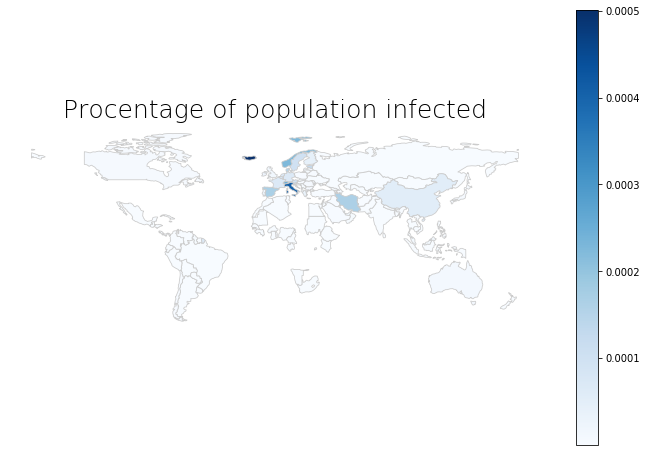

In [18]:
infected_map = world.set_index('name').join(procentage_cleaned.set_index("country"))
ax = create_plot_for_map("confirmed_proc", infected_map, "Procentage of population infected")
infected_map.plot(column="confirmed_proc", cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

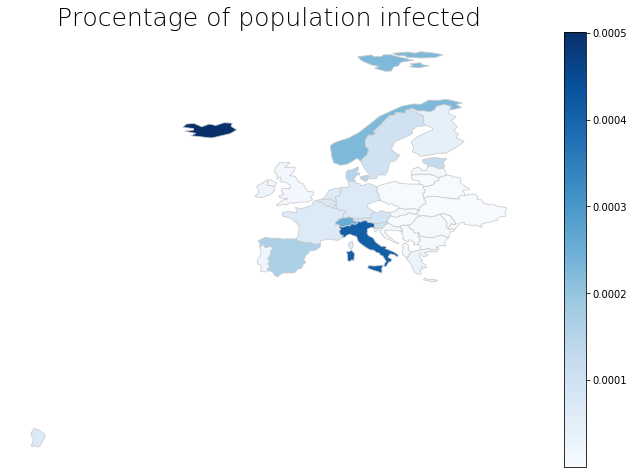

In [19]:
infected_map_with_names = infected_map
infected_map_with_names["name"] = infected_map.index.values
infected_europe = infected_map.query('continent == "Europe"')
infected_europe_without_russia = infected_europe[infected_europe['name'] != 'Russia']
ax = create_plot_for_map("confirmed_proc", infected_europe_without_russia, "Procentage of population infected")
infected_europe_without_russia.plot(column="confirmed_proc", cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')